# DEM数据稀疏化处理

本notebook演示如何将高分辨率的DEM数据插值到0.01°×0.01°的网格中，实现数据稀疏化。

In [1]:
import sys
sys.path.append('..')

from src.dem_interpolation import *
import rioxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.family'] = ['SimHei']

## 1. 加载原始DEM数据

In [2]:
# DEM文件路径
dem_file_path = r'h:\data\DEM\ASTGTM2_N23E111_dem.tif'

# 加载DEM数据
dem_data = load_dem_data(dem_file_path)

if dem_data is not None:
    print("\n原始数据信息:")
    print(f"数据形状: {dem_data.shape}")
    print(f"数据大小: {dem_data.nbytes / 1024 / 1024:.2f} MB")
    print(f"经度范围: {dem_data.x.min().values:.4f}° - {dem_data.x.max().values:.4f}°")
    print(f"纬度范围: {dem_data.y.min().values:.4f}° - {dem_data.y.max().values:.4f}°")

DEM数据已成功加载:
数据形状: (1, 3601, 3601)
数据大小: 24.73 MB

原始数据信息:
数据形状: (1, 3601, 3601)
数据大小: 24.73 MB
经度范围: 111.0000° - 112.0000°
纬度范围: 23.0000° - 24.0000°


## 2. 创建目标网格 (0.01°×0.01°)

In [3]:
# 创建0.01°×0.01°的目标网格
lon_grid, lat_grid = create_target_grid(dem_data, resolution=0.01)

# 显示网格信息
print(f"\n目标网格形状: {lon_grid.shape}")
print(f"网格点数: {lon_grid.size}")

目标网格信息:
经度范围: 110.9999° - 112.0099°
纬度范围: 22.9999° - 24.0099°
网格大小: 102 × 102
网格分辨率: 0.01°

目标网格形状: (102, 102)
网格点数: 10404


## 3. 执行插值

In [4]:
# 执行插值 - 使用快速向量化方法（推荐）
# 如果需要更平滑的结果但不介意慢一些，可以使用 method='linear'
interpolated_dem = interpolate_dem_to_grid(dem_data, lon_grid, lat_grid, method='vectorized')

print("\n插值结果信息:")
print(f"插值后数据形状: {interpolated_dem.shape}")
print(f"插值后数据大小: {interpolated_dem.nbytes / 1024 / 1024:.2f} MB")
print(f"数据压缩比: {dem_data.nbytes / interpolated_dem.nbytes:.2f}")

使用向量化插值方法（推荐）...
插值完成! 耗时: 0.47秒
插值后数据大小: 0.08 MB
数据压缩比: 311.59

插值结果信息:
插值后数据形状: (102, 102)
插值后数据大小: 0.08 MB
数据压缩比: 311.59


## 4. 可视化对比

对比图已保存到: dem_comparison.png


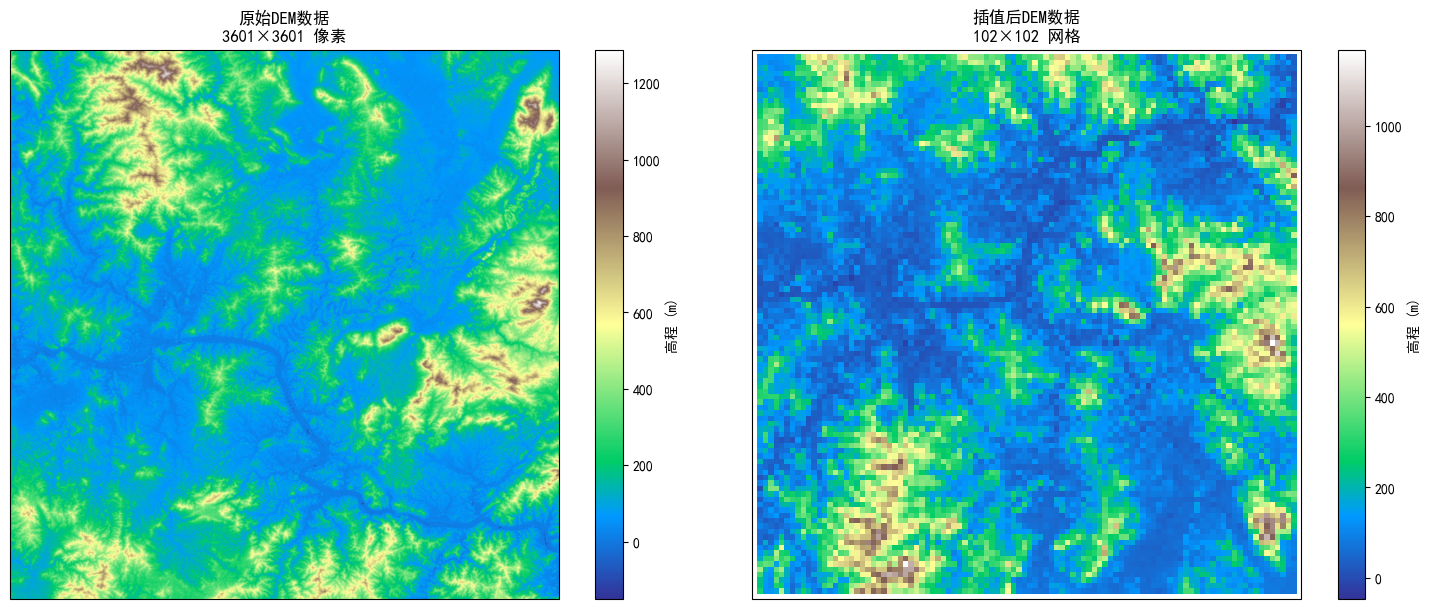

In [5]:
# 可视化原始数据和插值后的数据对比
visualize_comparison(dem_data, interpolated_dem, save_path='dem_comparison.png')

## 5. 保存结果

In [ ]:
# 保存插值后的数据
output_path = 'interpolated_dem_0.01deg.nc'
save_interpolated_data(interpolated_dem, output_path)

## 6. 数据统计信息

In [ ]:
# 显示数据统计信息
print("=== 数据统计信息 ===")
print(f"原始数据:")
print(f"  最小值: {dem_data.min().values:.2f} m")
print(f"  最大值: {dem_data.max().values:.2f} m")
print(f"  平均值: {dem_data.mean().values:.2f} m")
print(f"  标准差: {dem_data.std().values:.2f} m")

print(f"\n插值后数据:")
print(f"  最小值: {interpolated_dem.min().values:.2f} m")
print(f"  最大值: {interpolated_dem.max().values:.2f} m")
print(f"  平均值: {interpolated_dem.mean().values:.2f} m")
print(f"  标准差: {interpolated_dem.std().values:.2f} m")

# 计算数据差异
print(f"\n数据差异:")
print(f"  最小值差异: {interpolated_dem.min().values - dem_data.min().values:.2f} m")
print(f"  最大值差异: {interpolated_dem.max().values - dem_data.max().values:.2f} m")
print(f"  平均值差异: {interpolated_dem.mean().values - dem_data.mean().values:.2f} m")

## 7. 不同插值方法对比

In [ ]:
# 测试不同的插值方法，包括新的快速方法
methods = ['vectorized', 'fast_nearest', 'nearest', 'linear']
interpolated_results = {}

import time

print("=== 插值方法性能和质量对比 ===")
for method in methods:
    print(f"\n使用 {method} 插值方法...")
    try:
        start_time = time.time()
        result = interpolate_dem_to_grid(dem_data, lon_grid, lat_grid, method=method)
        elapsed_time = time.time() - start_time
        
        interpolated_results[method] = {
            'data': result,
            'time': elapsed_time
        }
        print(f"{method} 插值完成，耗时: {elapsed_time:.2f}秒")
    except Exception as e:
        print(f"{method} 插值失败: {e}")

# 比较不同方法的结果
if len(interpolated_results) > 1:
    print("\n=== 不同插值方法详细对比 ===")
    fastest_time = min([r['time'] for r in interpolated_results.values()])
    
    for method, result_info in interpolated_results.items():
        result = result_info['data']
        elapsed = result_info['time']
        speedup = fastest_time / elapsed
        
        print(f"{method}:")
        print(f"  耗时: {elapsed:.2f}秒 (速度倍数: {speedup:.1f}x)")
        print(f"  数据大小: {result.nbytes / 1024 / 1024:.2f} MB")
        print(f"  最小值: {result.min().values:.2f} m")
        print(f"  最大值: {result.max().values:.2f} m")
        print(f"  平均值: {result.mean().values:.2f} m")
        print(f"  标准差: {result.std().values:.2f} m")
        print()
    
    print("推荐:")
    print(f"- 速度优先: vectorized (最快)")
    print(f"- 质量优先: linear (最平滑，但最慢)")
    print(f"- 平衡选择: fast_nearest 或 nearest")